## Optimal Order Execution Region (spread long-short regions) and Trading Backtest

entering short at: 186.16
exiting short with growth: 8.757375708360115%, at: 171.17, total_value: 108.7573757083601
entering long at: 171.17
exiting long with growth: 13.343459718408617%, at: 194.01000000000002, total_value: 123.26937232680346
entering short at: 194.01000000000002
exiting short with growth: -1.2922920376494347%, at: 196.54999999999998, total_value: 121.67637204336374
entering long at: 196.54999999999998
exiting long with growth: 13.024675655049602%, at: 222.14999999999998, total_value: 137.52432485084333
entering short at: 222.14999999999998
exiting short with growth: 9.525218162993637%, at: 202.82999999999998, total_value: 150.62381682007023
entering long at: 202.82999999999998
exiting long with growth: 9.470985554405171%, at: 222.04, total_value: 164.8893767525928
entering short at: 222.04
exiting short with growth: 5.157470992185644%, at: 211.15, total_value: 173.39349852780347
entering long at: 211.15
exiting long with growth: 10.580156286999765%, at: 233.49, total

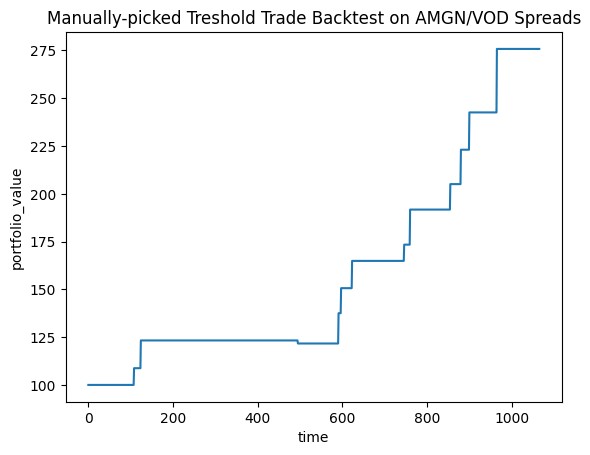

In [45]:
import os
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import matplotlib.pyplot as plt

# We define a backtesting method, that takes
# long-short tresholds and performs a backtest
# this is an oversimplified model that doesn't
# factor in the parameters of the underlying OU
# process and simply trades off arbitrarily
# defined tresholds, this follows an unoptimized
# P/L, which we will later optimize for risk
# appetite or optimality

TRAIN_SET_END = 1450
DATA_BASE = '../data/nasdaq/'
TICKER_BASE = 'AMGN'
TICKER_AUX = 'VOD'

base_path = os.path.join(DATA_BASE, TICKER_BASE + '.pkl')
aux_path = os.path.join(DATA_BASE, TICKER_AUX + '.pkl')

base = pd.read_pickle(base_path)
aux = pd.read_pickle(aux_path)
spreads = base - aux

def backtest(treshold_down: float, treshold_up: float):
    train_set_spreads = spreads[0:TRAIN_SET_END]

    test_set_spreads = spreads[TRAIN_SET_END:]
    test_set_len = len(test_set_spreads)

    # perform OLS fitting to X_{t} = \beta Y_{t} + \alpha
    x = list(range(len(train_set_spreads)))
    y = train_set_spreads[0]

    x = sm.add_constant(x)
    model = sm.OLS(y, x)
    res = model.fit()

    slope = res.params['x1']
    intercept = res.params['const']

    # perform backtest trading off tresholds
    total_value = 100
    portfolio_values = []

    entered_long = False
    long_entrance_price = 0

    entered_short = False
    short_entrance_price = 0

    enters_long = []
    enters_short = []

    for i in range(test_set_len):
        value = test_set_spreads.iloc[i, 0]

        real_time = TRAIN_SET_END + i
        pred_value = intercept + (slope * real_time)

        if pred_value + treshold_up < value:
            # End long position on spread
            if entered_long:
                entered_long = False
                growth = (value - long_entrance_price) / long_entrance_price
                total_value *= 1 + growth
                long_entrance_price = 0

                print(f'exiting long with growth: {growth * 100}%, at: {value}, total_value: {total_value}')   

            # short spread
            if not entered_short:
                entered_short = True
                short_entrance_price = value

                enters_short.append(i)
                print(f'entering short at: {value}')

        elif pred_value + treshold_down > value:
            # End short position on spread
            if entered_short:
                entered_short = False
                growth = (short_entrance_price - value) / value
                total_value *= 1 + growth
                short_entrance_price = 0

                print(f'exiting short with growth: {growth * 100}%, at: {value}, total_value: {total_value}')

            # long-spread
            if not entered_long:
                entered_long = True
                long_entrance_price = value

                enters_long.append(i)
                print(f'entering long at: {value}')

        portfolio_values.append(total_value)

    print(f'total startegy value: {total_value}')
    return portfolio_values, enters_long, enters_short, slope, intercept


TRADE_DOWN = -10
TRADE_UP = 6

portfolio, long_entrances, short_entrances, total_slope, total_intercept = backtest(TRADE_DOWN, TRADE_UP)
portfolio_df = pd.DataFrame({
    'time': range(len(portfolio)),
    'portfolio_value': portfolio
})

plt.title('Manually-picked Treshold Trade Backtest on AMGN/VOD Spreads')
sns.lineplot(data=portfolio_df, x='time', y='portfolio_value')
plt.show()

1066


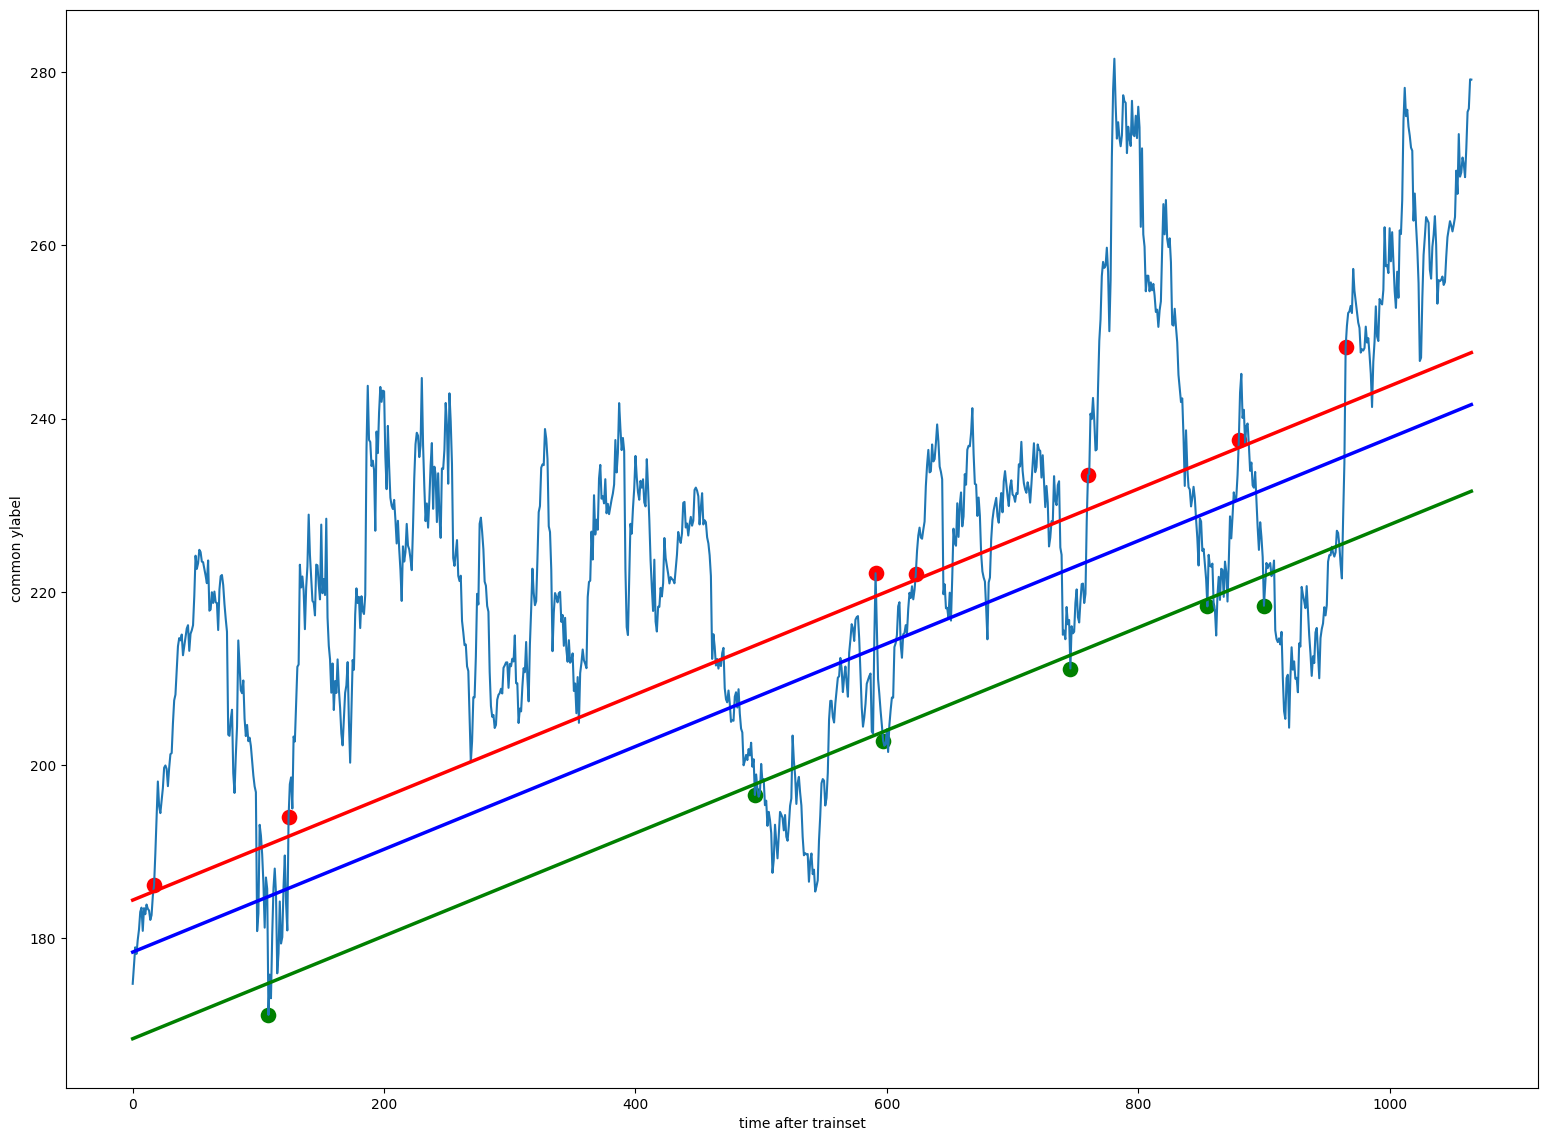

In [46]:
spreads = spreads[TRAIN_SET_END:]
print(len(spreads))

x = range(len(spreads))
spreads_df = pd.DataFrame({
    'x': x,
    'y': spreads[0]
})

plt.figure(figsize=(19, 14))

ax = sns.lineplot(data=spreads_df, x='x', y='y')

# Add long-short tresholds
y_down = [((p_x + TRAIN_SET_END) * total_slope) + total_intercept + TRADE_DOWN for p_x in x]
y_reg = [((p_x + TRAIN_SET_END) * total_slope) + total_intercept for p_x in x]
y_up = [((p_x + TRAIN_SET_END) * total_slope) + total_intercept + TRADE_UP for p_x in x]

tresholds_df = pd.DataFrame({
    'x': x,
    'y_down': y_down,
    'y_reg': y_reg,
    'y_up': y_up
})

sns.lineplot(data=tresholds_df, x='x', y='y_down', color='green', linewidth=2.5)
sns.lineplot(data=tresholds_df, x='x', y='y_reg', color='blue', linewidth=2.5)
sns.lineplot(data=tresholds_df, x='x', y='y_up', color='red', linewidth=2.5)

# Add trade entrances and exits
long_x = []
long_y = []

short_x = []
short_y = []

for x in long_entrances:
    y = spreads_df.iloc[x, 1]
    long_x.append(x)
    long_y.append(y)

for x in short_entrances:
    y = spreads_df.iloc[x, 1]
    short_x.append(x)
    short_y.append(y)

long_df = pd.DataFrame({
    'x': long_x,
    'y': long_y
})

short_df = pd.DataFrame({
    'x': short_x,
    'y': short_y
})

sns.scatterplot(data=long_df, x='x', y='y', color='green', s=150)
sns.scatterplot(data=short_df, x='x', y='y', color='red', s=150)

ax.set(xlabel='time after trainset', ylabel='common ylabel')
plt.show()

Consider a streategy that compares current $\theta$ levels against a treshold to execute a trade, we consider the OU process in its time discrete form
$$
X_{t + 1} = X_{t} + \theta \left ( \mu(t) - X_{t} \right )+ \sigma \Delta W_{n}
$$

We can take the mean-reverting force out of the time-discrete form, the force will be: $\theta \left ( \mu(t) - X_{t} \right )$

In [47]:
import ou

base_path = os.path.join(DATA_BASE, TICKER_BASE + '.pkl')
aux_path = os.path.join(DATA_BASE, TICKER_AUX + '.pkl')

base = pd.read_pickle(base_path)
aux = pd.read_pickle(aux_path)
spreads = base - aux

trainset = spreads[:TRAIN_SET_END].iloc[:, 0]
testset = spreads[TRAIN_SET_END:].iloc[:, 0]

print(len(trainset))

mean_coeff, mean_intercept, theta, sigma = ou.calibrate(trainset)

print(f'mu(t) = {mean_coeff}t + {mean_intercept}')
print(f'theta = {theta}')
print(f'sigma = {sigma}')

1450
mu(t) = 0.05933273399681959t + 92.3886877399938
theta = 0.022943374462635356
sigma = 2.3433270992078366


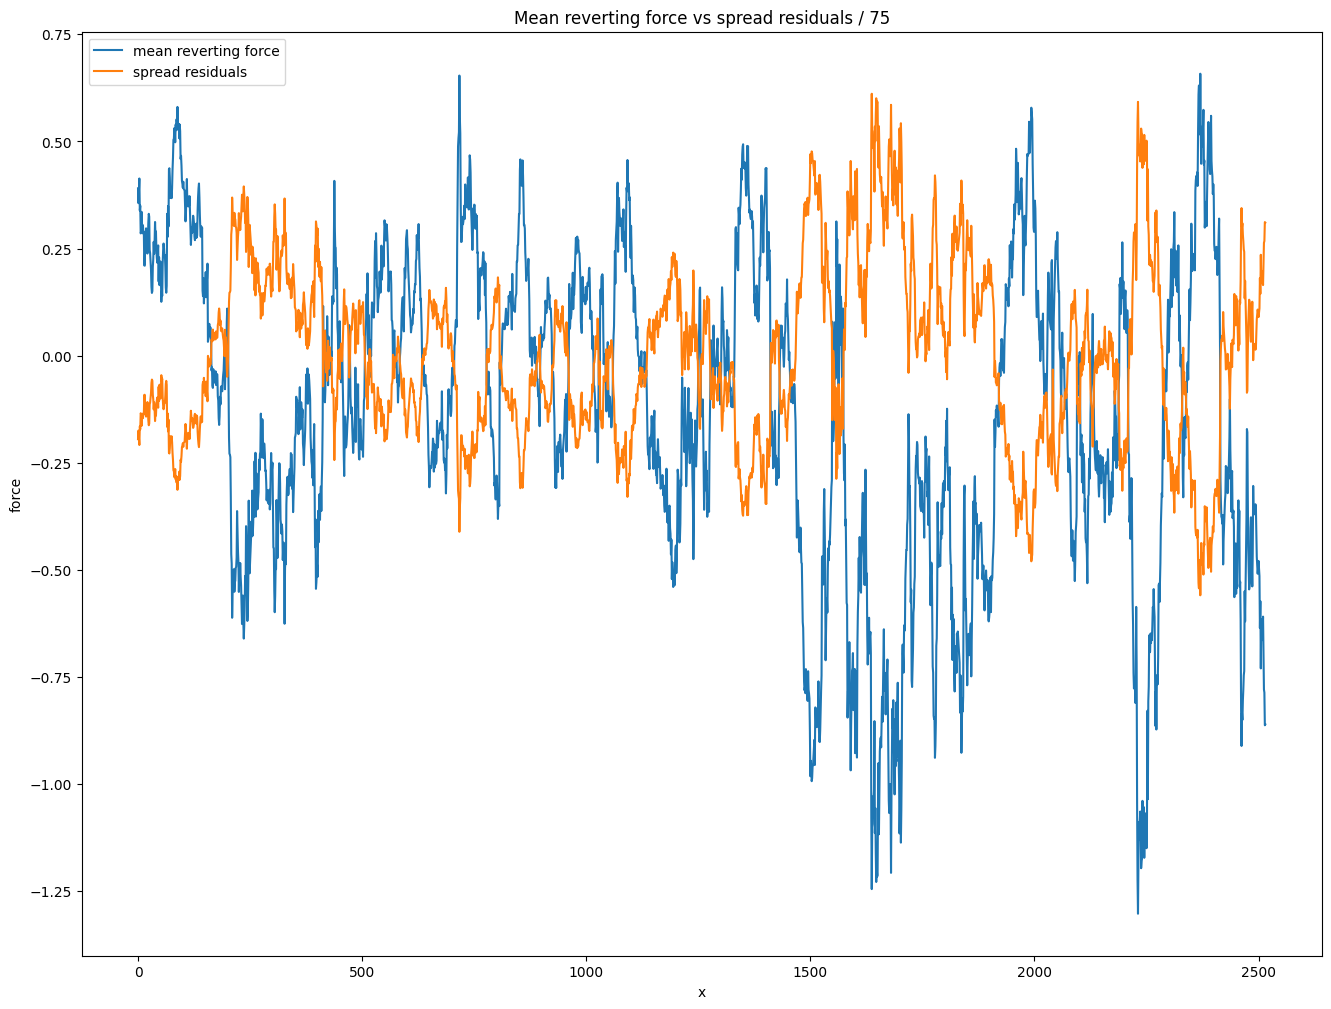

In [48]:
# graph mean reverting force in spreads

def mu(t):
    return (t * mean_coeff) + mean_intercept

forces = []
for index, row in spreads.iterrows():
    price = row[0]

    mean = mu(index)
    f = theta * (mean - price)

    forces.append(f)


# get residuals
x_param = sm.add_constant(spreads.index.to_list())
model = sm.OLS(spreads[0], x_param)
res = model.fit()

df = pd.DataFrame({
    'x': spreads.index.to_list(),
    'force': forces,
    'resid': res.resid / 75
})

plt.figure(figsize=(16, 12))
plt.title('Mean reverting force vs spread residuals / 75')
sns.lineplot(data=df, x='x', y='force', label='mean reverting force')
sns.lineplot(data=df, x='x', y='resid', label='spread residuals')
plt.show()

entering short at 1468
liquidating short at 1558
entering long at 1559
liquidating long at 1575
entering short at 1576
liquidating short at 1945
entering long at 1946
liquidating long at 2074
entering short at 2075
liquidating short at 2196
entering short at 2210
liquidating short at 2305
entering long at 2310
liquidating long at 2331
entering short at 2332
liquidating short at 2350
entering long at 2351
liquidating long at 2415
entering short at 2416
capital: 203.10593563249694


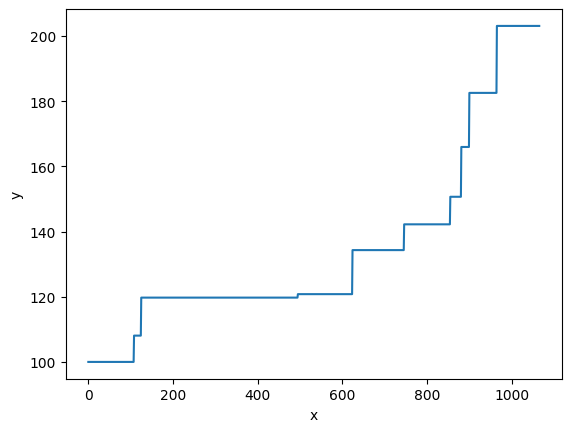

In [49]:
data = pd.DataFrame({
    'spread': testset,
    'base': base.iloc[TRAIN_SET_END:, 0],
    'aux': aux.iloc[TRAIN_SET_END:, 0]
})

class Position:
    def __init__(self, short: bool, entry: float, capital: float, entry_index: int) -> None:
        self.short = short
        self.entry = entry
        self.capital = capital
        self.entry_index = entry_index

    def liquidate(self, price: float) -> float:
        if not self.short:
            # long
            shares = self.capital / self.entry
            return shares * price
        else:
            # short
            price_delta = self.entry - price
            shares = self.capital / self.entry
            return (price_delta * shares) + self.capital


def alocate_capital_fractionally(cap, base, aux):
    total = base + aux
    num_shares = cap / total
    return num_shares * base, num_shares * aux


def backtest(signal_treshold):
    working_capital = 100

    base_position: Position = None
    aux_position: Position = None

    capital_progression = []
    long_trades = []
    short_trades = []

    for index, rows in data.iterrows():
        spread = rows['spread']
        base = rows['base']
        aux = rows['aux']

        # get mean reverting force at index
        mean = mu(index)
        force = theta * (mean - spread)

        if force > signal_treshold:
            # bet spread goes up
            # long base
            if base_position == None:
                print(f'entering long at {index}')
                base_cap, aux_cap = alocate_capital_fractionally(working_capital, base, aux)

                base_position = Position(False, base, base_cap, index)
                aux_position = Position(True, aux, aux_cap, index)

            elif base_position.short:
                # liquidate base short, aux long
                print(f'liquidating short at {index}')
                short_trades.append((base_position.entry_index, index))

                working_capital = base_position.liquidate(base)
                working_capital += aux_position.liquidate(aux)

                base_position = None
                aux_position = None

        elif -force > signal_treshold:
            # bet spread goes down
            # short base
            if base_position == None:
                print(f'entering short at {index}')
                base_cap, aux_cap = alocate_capital_fractionally(working_capital, base, aux)

                base_position = Position(True, base, base_cap, index)
                aux_position = Position(False, aux, aux_cap, index)
            elif not base_position.short:
                # liquidate base long, aux short
                print(f'liquidating long at {index}')
                long_trades.append((base_position.entry_index, index))

                working_capital = base_position.liquidate(base)
                working_capital += aux_position.liquidate(aux)

                base_position = None
                aux_position = None

        capital_progression.append(working_capital)

    return capital_progression, working_capital, long_trades, short_trades


capital_progression, capital, long_trades, short_trades = backtest(0.2)
print(f'capital: {capital}')

df = pd.DataFrame({
    'x': range(len(capital_progression)),
    'y': capital_progression
})

sns.lineplot(data=df, x='x', y='y')
plt.show()

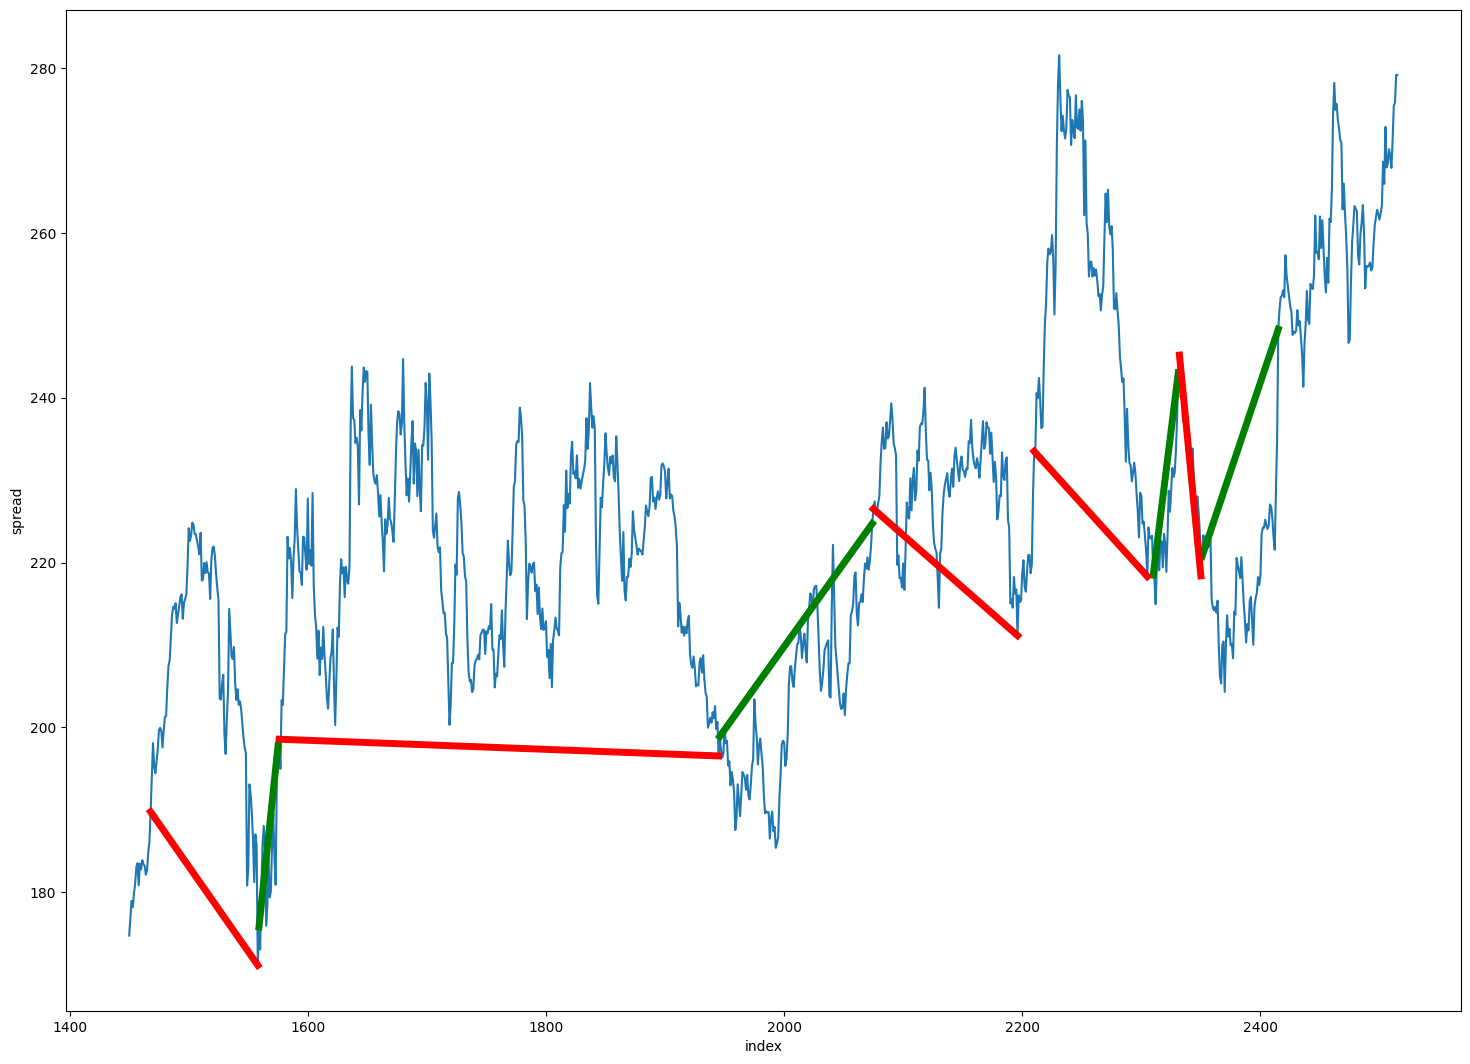

In [60]:
# show trade entrances and exits

data['index'] = data.index

plt.figure(figsize=(18, 13))

sns.lineplot(data=data, x='index', y='spread')

for (entry, exit) in long_trades:
    entry_y = data.loc[entry]['spread']
    exit_y = data.loc[exit]['spread']

    plt.plot([entry, exit], [entry_y, exit_y], linewidth=5, color='green')

for (entry, exit) in short_trades:
    entry_y = data.loc[entry]['spread']
    exit_y = data.loc[exit]['spread']

    plt.plot([entry, exit], [entry_y, exit_y], linewidth=5, color='red')


plt.show()

## Use 150-day SMA for mean function
$$
 \mu(t) = \frac{1}{n} \sum_{i = t - n}^{t} \mathcal{X}_{i} \text{, where } |\mathcal{X}| \ge n
$$

In [ ]:
def mean(t):
    